In [1]:
from functools import partial
from fvhoe.hydro import advection_dt
from fvhoe.initial_conditions import square
from fvhoe.solver import EulerSolver
import matplotlib.pyplot as plt
import numpy as np

import sys

sys.path.append("../../spd/src")
sys.path.append("../../spd/utils")

import initial_conditions as ic
from sdader_simulator import SDADER_Simulator

In [2]:
n_dims = 2
T = 1.0
DOFs = 32
p = 3
CFL = 0.6
cupy = False
first_order_integrator = False
slope_limiting = True
NAD_tol = 1e-5
NAD_range = "relative"

In [3]:
# finite volume solver
fv = EulerSolver(
    w0=square(
        dims={1: "x", 2: "xy", 3: "xyz"}[n_dims],
        vx=1,
        vy={1: 0, 2: 1, 3: 1}[n_dims],
        vz={1: 0, 2: 0, 3: 1}[n_dims],
    ),
    nx=DOFs,
    ny=DOFs if n_dims > 1 else 1,
    nz=DOFs if n_dims > 2 else 1,
    px=p,
    py=p if n_dims > 1 else 0,
    pz=p if n_dims > 2 else 0,
    riemann_solver="llf",
    CFL=CFL,
    a_posteriori_slope_limiting=slope_limiting,
    NAD=NAD_tol,
    NAD_mode="local",
    NAD_range=NAD_range,
    cupy=cupy,
)
if first_order_integrator:
    fv.euler(T)
else:
    fv.run(T)

# finite element solver
sd = SDADER_Simulator(
    p=p,
    m=0 if first_order_integrator else -1,
    N=(DOFs // (p + 1),) * n_dims,
    init_fct=ic.step_function(),
    cfl_coeff=CFL,
    update="FV" if slope_limiting else "SD",
    FB=slope_limiting,
    tolerance=NAD_tol,
    NAD={"relative": "delta", "absolute": ""}[NAD_range],
    use_cupy=cupy,
)
sd.perform_time_evolution(T)

100%|██████████| 1.0/1.0 [00:04]                 
/home/jp7427/Desktop/FVHOE/experiments/notebooks/../../spd/src/trouble_detection.py:125: RuntimeWarning: divide by zero encountered in divide
  -np.where(dv < 0, np.where(vL > 0, vL, 0), np.where(vL < 0, vL, 0)) / dv
/home/jp7427/Desktop/FVHOE/experiments/notebooks/../../spd/src/trouble_detection.py:125: RuntimeWarning: invalid value encountered in divide
  -np.where(dv < 0, np.where(vL > 0, vL, 0), np.where(vL < 0, vL, 0)) / dv
/home/jp7427/Desktop/FVHOE/experiments/notebooks/../../spd/src/trouble_detection.py:132: RuntimeWarning: divide by zero encountered in divide
  alphaR = np.where(dv > 0, np.where(vR > 0, vR, 0), np.where(vR < 0, vR, 0)) / dv
/home/jp7427/Desktop/FVHOE/experiments/notebooks/../../spd/src/trouble_detection.py:132: RuntimeWarning: invalid value encountered in divide
  alphaR = np.where(dv > 0, np.where(vR > 0, vR, 0), np.where(vR < 0, vR, 0)) / dv
/home/jp7427/Desktop/FVHOE/experiments/notebooks/../../spd/src/muscl

t=1.0, steps taken 233, time taken 3.4672048499342054


Text(0.5, 1.0, 'sd')

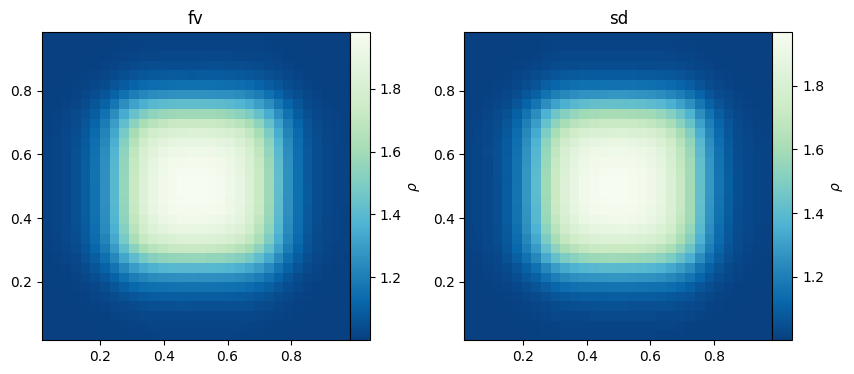

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

if n_dims == 2:
    # fv plot
    fv_im = fv.plot_2d_slice(axs[0], param="rho", z=0.5)
    fv_im_ax = fig.add_axes(
        [
            axs[0].get_position().x0 + axs[0].get_position().width,
            axs[0].get_position().y0,
            0.02,
            axs[0].get_position().height,
        ]
    )
    fig.colorbar(fv_im, cax=fv_im_ax, label=r"$\rho$")

    # sd plot
    sd_data = np.rot90(sd.transpose_to_fv(sd.regular_mesh(sd.dm.W_cv))[0], k=1)
    x, y = sd.regular_faces()
    x, y = 0.5 * (x[1:] + x[:-1]), 0.5 * (y[1:] + y[:-1])
    sd_im = axs[1].imshow(
        sd_data, cmap="GnBu_r", extent=(x.min(), x.max(), y.min(), y.max())
    )
    sd_im_ax = fig.add_axes(
        [
            axs[1].get_position().x0 + axs[1].get_position().width,
            axs[1].get_position().y0,
            0.02,
            axs[1].get_position().height,
        ]
    )
    fig.colorbar(sd_im, cax=sd_im_ax, label=r"$\rho$")

axs[0].set_title("fv")
axs[1].set_title("sd")